In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# load the data
border_df = pd.read_csv('Border_Crossing_Entry_Data.csv')

# convert date to datetime and extract year 
border_df['Date'] = pd.to_datetime(border_df['Date'].str.strip(), errors='coerce')
border_df['Year'] = border_df['Date'].dt.year

# drop missing values
border_df = border_df.dropna()

# label encode columns
label_columns = ['Port Name', 'State', 'Measure', 'Border']
label_encoder = LabelEncoder()
for column in label_columns:
    border_df[column] = label_encoder.fit_transform(border_df[column])

# predict future increase/decrease
border_df['Prev_Year_Value'] = border_df.groupby(['Port Code', 'Measure'])['Value'].shift(1)

# drop rows with na values
border_df = border_df.dropna(subset=['Prev_Year_Value'])

# define the target variable # 1 if value increased, 0 if decreased
border_df['Value_Change'] = border_df['Value'] > border_df['Prev_Year_Value'] 
border_df['Value_Change'] = border_df['Value_Change'].astype(int)

# define features (X) and target (y)
features = ['Port Code', 'State', 'Border', 'Measure', 'Year', 'Prev_Year_Value', 'Latitude', 'Longitude']
X = border_df[features]
y = border_df['Value_Change']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Accuracy: 0.7805382235073302
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     51042
           1       0.69      0.68      0.69     27810

    accuracy                           0.78     78852
   macro avg       0.76      0.76      0.76     78852
weighted avg       0.78      0.78      0.78     78852



In [3]:
#calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index = ["Decrease (0)", "Increase (1)"]
)
print("Confusion Matrix")
cm_df

Confusion Matrix


,0,1
Decrease (0),42609,8433
Increase (1),8872,18938


In [ ]:
#The model correctly predicted future decreases in 42,609 cases. It's predictions in decreases was incorrect in 8,433 cases.
#The model correctly predicted future increases in 18,938 cases. It's predictions in increases was incorrect in 8,872 cases. 

#Overall, the model predicted that there will be more decreases than increases in the future. 

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

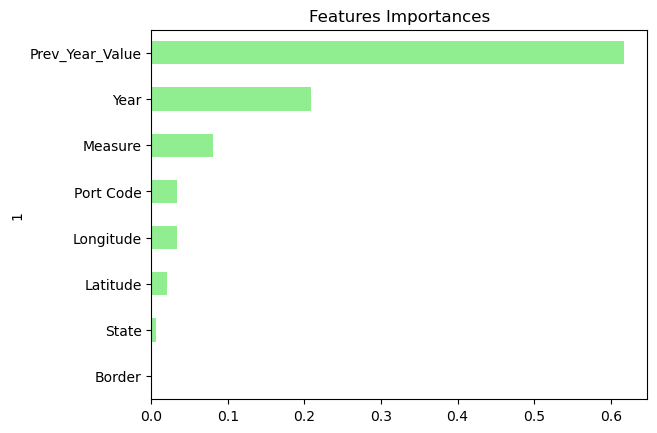

In [4]:
#feature importance
importances = model.feature_importances_

sorted(zip(model.feature_importances_, X.columns), reverse=True)

importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)